In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\G04_FoG_trial_1_emg.csv
.\data\G04_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_1_emg.csv
.\data\G06_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_3_emg.csv
.\data\G07_Freezing_Trial1_trial_1_emg.csv
.\data\G08_FoG_1_trial_1_emg.csv
.\data\G08_FoG_2_trial_1_emg.csv
.\data\G11_FoG_trial_1_emg.csv
.\data\G11_FoG_trial_2_emg.csv
.\data\labels.txt
.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_3_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_3_emg.csv
.\data\P551_M050_2_A_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\P812_M050_2_B_FoG_trials.mat
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_

In [241]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv')
emg_data2 = pd.read_csv('.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv')
emg_data3 = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_2_emg.csv')

In [75]:
emg_data3.Label2.value_counts()

0    16143
2     4962
1      721
Name: Label2, dtype: int64

In [243]:
emg_data = emg_data.fillna({'LEFT_BF':emg_data.LEFT_BF.mean(),
                           'LEFT_RF':emg_data.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [244]:
emg_data2 = emg_data2.fillna({'RIGHT_TA':emg_data2.RIGHT_TA.mean()})
emg_data2.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [242]:
emg_data3 = emg_data3.fillna({'LEFT_BF':emg_data3.LEFT_BF.mean(),
                           'LEFT_RF':emg_data3.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data3.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data3.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data3.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data3.RIGHT_RF.mean()})
emg_data3.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [245]:
def scale_data(data,scaler):
    X = data.iloc[:,3:]
    X = sc.fit_transform(X)
    data.iloc[:,3:] = X
    return data

def generate_window_slide_data(data,width = 256,stride = 32):
    l = len(data)
    end = (l-width)//stride+1
    X = []
    Y = []
    sc = StandardScaler(with_mean=False)
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
                Y += [data.Label2[i*stride]]
                #x_sc = sc.fit_transform(np.array(data.iloc[i*stride:i*stride+width,3:]))
                #X += [x_sc]
                X += [np.array(data.iloc[i*stride:i*stride+width,3:])]
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.uint8)

#def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
#    n,t,c = data.shape
#    cwtmatr = np.zeros((n,widths,t,c))
#    for i in range(n):
#        for j in range(c):
#            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
#    return cwtmatr


def generate_CWT_feature(data,widths=260,wavelet = 'mexh'):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c))
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j],_ = pywt.cwt(data[i,:,j],np.arange(1,widths+1),wavelet)
    return cwtmatr

In [204]:
sc = StandardScaler()
#sc.fit(emg_data.iloc[:,3:])
emg_data_sc = scale_data(emg_data,sc)
emg_data_sc2 = scale_data(emg_data3,sc)
#emg_data_sc.iloc[:,8].plot()

In [260]:
width = 256
stride = 32
widths_scale = 32
x,y = generate_window_slide_data(emg_data,width,stride)
x2,y2 = generate_window_slide_data(emg_data2,width,stride)

In [261]:
emg_data.Label2.value_counts()

2    39366
0    25373
1     7808
3     4922
4     2362
Name: Label2, dtype: int64

In [262]:
start = time.time()
#cwtmatr = generate_CWT_feature(x,widths_scale,'mexh')
cwtmatr2 = generate_CWT_feature(x2,widths_scale,'mexh')
end = time.time()
duration = end-start
print('duration: %f'%(duration))

duration: 15.472022


In [263]:
#cwtmatr=StandardScaler(cwtmatr)
cwtmatr2.max()

4276.8759765625

In [252]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [9]:
import h5py

file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(width,stride,widths_scale)
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=cwtmatr, maxshape=(None,260,260,8),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=y, dtype = np.int8)

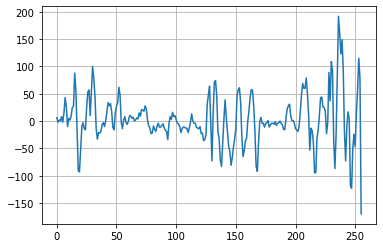

In [264]:
plt.plot(x2[200,:,0])
plt.grid(True)

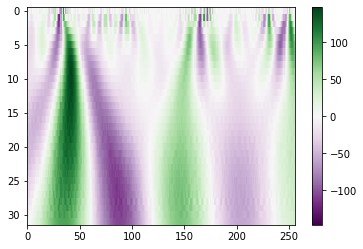

3


In [265]:
temp = 200
channel = 0
plt.imshow(cwtmatr[temp,:,:,channel], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[temp,:,:,channel]).max(), 
           vmin=-abs(cwtmatr[temp,:,:,channel]).max())
plt.colorbar()
plt.show()
print(y[temp])

In [156]:
#label = y[ind]
#label[label==2]=1


In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras import callbacks, Model
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,confusion_matrix
import tensorflow as tf
from tensorflow.keras import backend as K

In [253]:
ind = ((y==0) | (y==2))
y_02 = y[ind]
y_02[y_02==2]=1
X_full,X_test,y_full,y_test = train_test_split(cwtmatr[ind],y_02,test_size = 0.2,random_state=60)
X_train,X_valid,y_train,y_valid= train_test_split(X_full,y_full,test_size = 0.2,random_state=60)

In [254]:
input_ = layers.Input(shape=cwtmatr.shape[1:])
#max_pool = layers.MaxPooling2D(2)(input_)
bn = layers.BatchNormalization()(input_)
conv1 = layers.Conv2D(128,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(bn)
max_pool1 = layers.MaxPooling2D(2)(conv1)
conv2 = layers.Conv2D(64,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(max_pool1)
max_pool2 = layers.MaxPooling2D(2)(conv2)
flatten = layers.Flatten()(max_pool2)
#layer1 = Dense(256,activation = 'relu')(flatten)
dropout1 = layers.Dropout(0.3)(flatten)
layer2 = layers.Dense(128,activation = 'relu')(dropout1)
dropout2 = layers.Dropout(0.3)(layer2)
output = layers.Dense(2,activation = 'softmax')(dropout2)
model = keras.Model(inputs=[input_],outputs=[output])

In [255]:
#ind = ((y==0) | (y==2))
#bce = CategoricalCrossentropy()
model.compile(loss = 'sparse_categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])
#oh_ec = OneHotEncoder()
#label = oh_ec.fit_transform(K.eval(y)[ind,tf.newaxis]).toarray()

In [256]:
early_stopping = callbacks.EarlyStopping(patience = 10,monitor = 'val_accuracy', restore_best_weights=True)

In [257]:
history = model.fit(X_train,y_train,validation_data=[X_valid,y_valid],
                    epochs=100,batch_size=50,
                   callbacks=[early_stopping])

Train on 1173 samples, validate on 294 samples
Epoch 1/100
1173/1173 [==============================] - 18s 15ms/sample - loss: 0.8040 - accuracy: 0.6164 - val_loss: 1.2158 - val_accuracy: 0.6463
Epoch 2/100
1173/1173 [==============================] - 15s 13ms/sample - loss: 0.5594 - accuracy: 0.6735 - val_loss: 0.6146 - val_accuracy: 0.6599
Epoch 3/100
1173/1173 [==============================] - 14s 12ms/sample - loss: 0.4875 - accuracy: 0.7451 - val_loss: 0.5511 - val_accuracy: 0.7449
Epoch 4/100
1173/1173 [==============================] - 14s 12ms/sample - loss: 0.4124 - accuracy: 0.8397 - val_loss: 0.6658 - val_accuracy: 0.7279
Epoch 5/100
1173/1173 [==============================] - 14s 12ms/sample - loss: 0.3455 - accuracy: 0.8593 - val_loss: 0.3755 - val_accuracy: 0.8469
Epoch 6/100
1173/1173 [==============================] - 17s 15ms/sample - loss: 0.2573 - accuracy: 0.9062 - val_loss: 0.3610 - val_accuracy: 0.8673
Epoch 7/100
1173/1173 [==============================] - 15

In [258]:
model.evaluate(X_test,y_test)

367/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.14391287544117962, 0.95640326]

In [228]:
y_pred = model.predict(X_full)
oh_ec = OneHotEncoder()
label = oh_ec.fit_transform(y_full[:,np.newaxis]).toarray()
precision, recall, threshold = precision_recall_curve(label[:,0],y_pred[:,0])

array([[522,   3],
       [  7, 935]], dtype=int64)

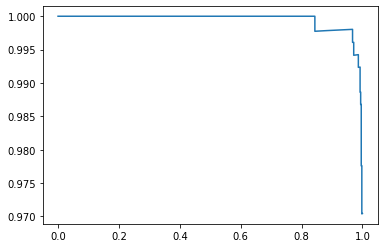

In [229]:
plt.plot(recall,precision)
confusion_matrix(y_full,np.where(y_pred<0.5,1,0)[:,0])

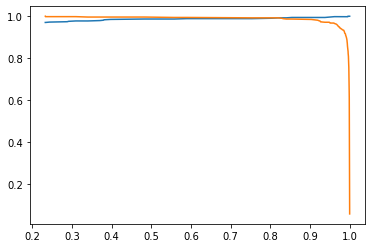

In [231]:
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])

In [266]:
#model = load_model('./model/Mexh_W256_S32_WS32.h5')
ind = (y2==0)|(y2==2)
y_02=y2[ind]
y_02[y_02==2]=1
model.evaluate(cwtmatr2[ind],y_02)

700/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[4.900847364882939, 0.63857144]

In [151]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

array([[ 651,    7],
       [   9, 1167]], dtype=int64)

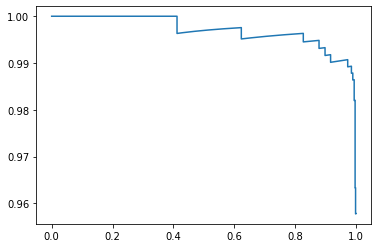

In [53]:
y_pred = model.predict(cwtmatr[ind])
oh_ec = OneHotEncoder()
label = oh_ec.fit_transform(y_02[:,np.newaxis]).toarray()
precision, recall, threshold = precision_recall_curve(label[:,0],y_pred[:,0])
plt.plot(recall,precision)
confusion_matrix(y_02,np.where(y_pred<0.5,1,0)[:,0])

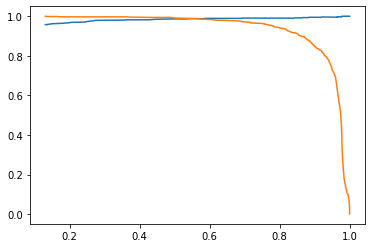

In [54]:
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])

In [232]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 256, 8)]      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 256, 8)        32        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 128, 128)      25728     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 64, 128)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 32, 64)         204864    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 16, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0   

(0, 1)

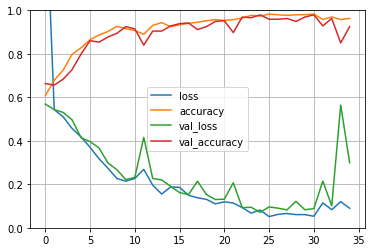

In [22]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)

In [39]:
model.save('./model/Mexh_W%d_S%d_WS%d.h5'%(width,stride,widths_scale))